In [1]:
import numpy as np
import torch.nn.functional as F
import torch
import os
import random

from torch import nn
from torch import optim
from torch.utils.data import TensorDataset, DataLoader
from eeg_feature_extraction.eeg_utils import *
from models import *

random.seed(42)

GPU not available, CPU used


In [2]:
# load all word embeddings into memory
all_embeddings = load_embeddings()

embeddings_nca_nr = all_embeddings[0]
embeddings_nca_tsr = all_embeddings[1]
embeddings_randomforest_nr = all_embeddings[2]
embeddings_randomforest_tsr = all_embeddings[3]

assert embeddings_randomforest_nr.shape == embeddings_nca_nr.shape
assert embeddings_randomforest_tsr.shape == embeddings_nca_tsr.shape

# get indices for held out test sentences
held_out_sents_nr = get_held_out_sents('task2')
held_out_sents_tsr = get_held_out_sents('task3')

# get number of sentences per task without held out test sentences
n_sents_nr = len(get_sent_lens_per_task('task2', held_out_sents_nr))
n_sents_tsr = len(get_sent_lens_per_task('task3', held_out_sents_tsr))

In [3]:
# reshape word embeddings into tensors of size N (number of sents) x T (sequence length per task) x D (embeddings dim)
embeddings_randomforest_nr_seq = reshape_into_tensor(embeddings_randomforest_nr, 'task2')
embeddings_randomforest_tsr_seq = reshape_into_tensor(embeddings_randomforest_tsr, 'task3')
embeddings_nca_nr_seq = reshape_into_tensor(embeddings_nca_nr, 'task2')
embeddings_nca_tsr_seq = reshape_into_tensor(embeddings_nca_tsr, 'task3')

assert embeddings_randomforest_nr_seq.shape == embeddings_nca_nr_seq.shape
assert embeddings_randomforest_tsr_seq.shape == embeddings_nca_tsr_seq.shape
assert embeddings_randomforest_nr_seq.shape[0] == embeddings_nca_nr_seq.shape[0] == n_sents_nr
assert embeddings_randomforest_tsr_seq.shape[0] == embeddings_nca_tsr_seq.shape[0] == n_sents_tsr

In [4]:
# vertically stack sequences on top of each other to create whole sequence data set
all_seq_randomforest = torch.cat((embeddings_randomforest_nr_seq , embeddings_randomforest_tsr_seq ), 0)
all_seq_nca = torch.cat((embeddings_nca_nr_seq , embeddings_randomforest_tsr_seq ), 0)

assert all_seq_randomforest.shape == all_seq_nca.shape

In [5]:
# create labels vector
labels_nr, labels_tsr = torch.zeros(n_sents_nr, dtype = torch.double), torch.ones(n_sents_tsr, dtype = torch.double)
all_labels = torch.cat((labels_nr, labels_tsr), 0)

In [6]:
# split data set into 80% train, 20% dev
n_seq_total = n_sents_nr + n_sents_tsr
n_val_seq = n_seq_total // 10 * 2
n_train_seq = n_seq_total - n_val_seq
val_indices = list(set(random.sample(list(range(n_seq_total)), k = n_val_seq)))
train_indices = [i for i in range(n_seq_total) if i not in val_indices]

In [7]:
# create train and dev sets
X_train_rf = all_seq_randomforest[train_indices]
X_train_nca = all_seq_nca[train_indices]
y_train =  all_labels[train_indices]

X_val_rf = all_seq_randomforest[val_indices]
X_val_nca = all_seq_nca[val_indices]
y_val =  all_labels[val_indices]

In [46]:
# define hyperparameters
output_size = 1
seq_length = 20
embedding_dim = 45
hidden_dim = 50
n_layers = 2
batch_size = 32
lr = 0.01

In [10]:
# create data loaders for both embeddings extracted via random forest and nca embeddings
train_loader_rf, val_loader_rf = get_data_batches(X_train_rf, y_train, X_val_rf, y_val, batch_size)
train_loader_nca, val_loader_nca = get_data_batches(X_train_nca, y_train, X_val_nca, y_val, batch_size)

In [86]:
# instantiate the model with pre-defined hyperparameters
model = VanillaLSTM(embedding_dim, hidden_dim, output_size, n_layers)

# we'll also set the model to the device that we defined earlier (default is CPU)
# model has to be converted to dtype double
model = model.double()
model.to(device)

# we need binary cross entropy closs as we are dealing with a binary classification task
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

In [87]:
epochs = 10
counter = 0
print_every = 10
clip = 5
valid_loss_min = np.Inf

In [88]:
model.train()
train_losses, train_accs = [], []
val_losses, val_accs = [], []
for i in range(epochs):
    h = model.init_hidden(batch_size)
    train_losses_epoch, train_accs_epoch = [], []
    for inputs, labels in train_loader_nca:
        counter += 1
        # Creating new variables for the hidden state, otherwise
        # we'd backprop through the entire training history
        h = tuple([e.data.double() for e in h])
        inputs, labels = inputs.to(device), labels.to(device)
        model.zero_grad()
        if (inputs.shape[0], inputs.shape[1]) == (batch_size, seq_length):
            output, h = model(inputs, h)
            loss = criterion(output.squeeze(), labels.double())
            train_losses_epoch.append(loss.item())
            loss.backward()
            nn.utils.clip_grad_norm_(model.parameters(), clip)
            optimizer.step()
            train_acc = accuracy(output.squeeze(), labels)
            train_accs_epoch.append(train_acc)

        if counter % print_every == 0:
            val_h = model.init_hidden(batch_size)
            val_losses_epoch, val_accs_epoch = [], []
            model.eval()
            # no gradient computation for evaluation mode
            with torch.no_grad():
                for xb_val, yb_val in val_loader_nca:
                    if (xb_val.shape[0], xb_val.shape[1]) == (batch_size, seq_length):
                        val_h = tuple([each.data.double() for each in val_h])
                        inp, lab = xb_val.to(device), yb_val.to(device)
                        out, val_h = model(inp, val_h)
                        val_loss = criterion(out.squeeze(), lab.double())
                        acc = accuracy(out, lab)
                        val_accs_epoch.append(acc)
                        val_losses_epoch.append(val_loss.item())
            
            model.train()
            print("Epoch: {}/{}...".format(i+1, epochs),
                  "Step: {}...".format(counter),
                  "Train Loss: {:.6f}...".format(loss.item()),
                  "Train Acc: {:.6f}...".format(np.mean(train_accs_epoch)),
                  "Val Loss: {:.6f}...".format(np.mean(val_losses_epoch)),
                  "Val Acc: {:.6f}".format(np.mean(val_accs_epoch)))

            if np.mean(val_losses) <= valid_loss_min:
                torch.save(model.state_dict(), './state_dict.pt')
                print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(valid_loss_min,np.mean(val_losses)))
                valid_loss_min = np.mean(val_losses)
    train_losses.append(np.mean(train_losses_epoch))
    train_accs.append(np.mean(train_accs_epoch))
    val_losses.append(np.mean(val_losses_epoch))
    val_accs.append(np.mean(val_accs_epoch))

Epoch: 1/10... Step: 10... Train Loss: 0.261728... Train Acc: 0.890625... Val Loss: 0.603582... Val Acc: 0.835938


C:\Users\Lukas\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3257: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\Lukas\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\core\_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Epoch: 2/10... Step: 20... Train Loss: 0.025871... Train Acc: 1.000000... Val Loss: 0.015982... Val Acc: 1.000000
Validation loss decreased (inf --> 0.603582).  Saving model ...
Epoch: 2/10... Step: 30... Train Loss: 0.009474... Train Acc: 0.997596... Val Loss: 0.005099... Val Acc: 1.000000
Validation loss decreased (0.603582 --> 0.603582).  Saving model ...
Epoch: 3/10... Step: 40... Train Loss: 0.005750... Train Acc: 1.000000... Val Loss: 0.002048... Val Acc: 1.000000
Validation loss decreased (0.603582 --> 0.304340).  Saving model ...
Epoch: 3/10... Step: 50... Train Loss: 0.003645... Train Acc: 0.998047... Val Loss: 0.101257... Val Acc: 0.984375
Validation loss decreased (0.304340 --> 0.304340).  Saving model ...
Epoch: 4/10... Step: 60... Train Loss: 0.001696... Train Acc: 1.000000... Val Loss: 0.000962... Val Acc: 1.000000
Validation loss decreased (0.304340 --> 0.236646).  Saving model ...
Epoch: 5/10... Step: 70... Train Loss: 0.002930... Train Acc: 1.000000... Val Loss: 0.0010

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

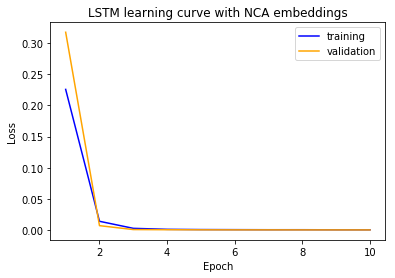

In [85]:
plt.plot(range(1,11), train_losses, color='blue')
plt.plot(range(1,11), val_losses, color='orange')
plt.title("LSTM learning curve with NCA embeddings")
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['training', 'validation'], loc='upper right')

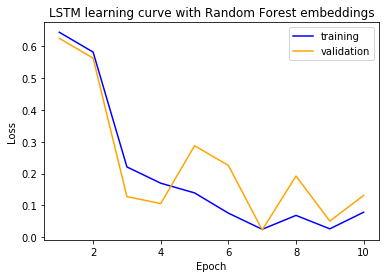

In [82]:
plt.plot(range(1,11), train_losses, color='blue')
plt.plot(range(1,11), val_losses, color='orange')
plt.title("LSTM learning curve with Random Forest embeddings")
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['training', 'validation'], loc='upper right')

In [ ]:
# Loading the best model
model.load_state_dict(torch.load('./state_dict.pt'))

test_losses = []
num_correct = 0
h = model.init_hidden(batch_size)

model.eval()
for inputs, labels in test_loader:
    h = tuple([each.data for each in h])
    inputs, labels = inputs.to(device), labels.to(device)
    output, h = model(inputs, h)
    test_loss = criterion(output.squeeze(), labels.float())
    test_losses.append(test_loss.item())
    pred = torch.round(output.squeeze())  # Rounds the output to 0/1
    correct_tensor = pred.eq(labels.float().view_as(pred))
    correct = np.squeeze(correct_tensor.cpu().numpy())
    num_correct += np.sum(correct)

print("Test loss: {:.3f}".format(np.mean(test_losses)))
test_acc = num_correct/len(test_loader.dataset)
print("Test accuracy: {:.3f}%".format(test_acc*100))